# Climatologies and validation data

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layers
- Querying the data layers
    - Point query
    - Raster query
- References


## Overview

The climatology was calculated by the IBM Future of Climate team from ERA5 data spanning 1991-2020. The methodology for calculation was similar to that used in the ERA-interim climatology. That is, a 61 day weighted rolling window with the weights decreasing linearly from their maximum value at the center of the window to zero at +-30 days. This is in contrast to those references (and the ERA-interim climatology), where weights are determined by second-order polynomial. The daily data is stored in Geospatial ranging between Jan 1 2020 to Dec 31 2020. This dataset is mainly used to compare current or forecasted weather data with historical climate benchmark and observe how much it varies with the historical norm as demonstrated in [this](../../weather_forecast/twc_spfp_weather_prediction.ipynb) tutorial.

Let us get a practical understanding about this dataset and its usage through this tutorial.

## Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample ,mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib
%pip install ipyplot

In [1]:
import ibmpairs.client as client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import pandas as pd
import configparser
import json
import numpy as np
from PIL import Image as PILImage
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import ipyplot


Now, let us create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

### Get authentication token

In [2]:
config = configparser.RawConfigParser()
config.read('../../../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id')  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                    tenant_id = EI_TENANT_ID,
                                    org_id    = EI_ORG_ID,
                                    legacy    = False,
                                    version   = 3
                                   )

2025-01-20 19:14:52 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-20 19:14:52 - paw - INFO - Legacy Environment is False
2025-01-20 19:14:52 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-20 19:15:15 - paw - INFO - Authentication success.
2025-01-20 19:15:15 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Data layers

We shall start by querying the ibmpairs catalog to retrieve the Data Set ID and the Data Layers that form the Data Set.

In [102]:
pd.set_option('display.max_colwidth', None)
search_df=catalog.search("Climatologies and validation data")
search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,524,51198,Precipitation Daily Climo 1991 to 2020,Precip weighted daily climatology from ERA5 1991 to 2020. The daily data is stored in PAIRS with dates Jan 1 2020 to Dec 31 2020.,12,Raster,,Climatologies and validation data,"Daily climatologies calculated from the fifth generation atmospheric reanalysis of the global climate (ERA5) from 1991 to 2020, that are equivalent to Geospatial APIs dataset 190."
1,524,51199,Temperature 2m Daily Climo 1991 to 2020,T2-Ave weighted daily climatology from ERA5 1991 to 2020. The daily data is stored in PAIRS with dates Jan 1 2020 to Dec 31 2020.,12,Raster,,Climatologies and validation data,"Daily climatologies calculated from the fifth generation atmospheric reanalysis of the global climate (ERA5) from 1991 to 2020, that are equivalent to Geospatial APIs dataset 190."
2,524,51200,Temperature 2m Max Daily Climo 1991 to 2020,T2-Max weighted daily climatology from ERA5 1991 to 2020. The daily data is stored in PAIRS with dates Jan 1 2020 to Dec 31 2020.,12,Raster,,Climatologies and validation data,"Daily climatologies calculated from the fifth generation atmospheric reanalysis of the global climate (ERA5) from 1991 to 2020, that are equivalent to Geospatial APIs dataset 190."
3,524,51217,Temperature 2m Min Daily Climo 1991 to 2020,T2-Min weighted daily climatology from ERA5 1991 to 2020. The daily data is stored in PAIRS with dates Jan 1 2020 to Dec 31 2020.,12,Raster,,Climatologies and validation data,"Daily climatologies calculated from the fifth generation atmospheric reanalysis of the global climate (ERA5) from 1991 to 2020, that are equivalent to Geospatial APIs dataset 190."


As seen above, the Climatologies and validation data set of ID 524 has four Data Layers. Each of the Data Layers are identified by a unique Data Layer ID.
To gain a better understanding of the Data Set and its geospatial and temporal coverage as well as other relevant metadata, we can make further queries to the ibmpairs catalog submodule as mentioned in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

## Querying the data layers

### Point query 
Next, we shall make a point query for four different locations to observe the climatic conditions in the specified locations.

In [103]:
query_result = query.submit({
      "layers" : [
          {
              "type" : "raster", 
              "id" : "51198"
          },
          {
              "type" : "raster",
              "id" : "51199"
          },
          {
              "type" : "raster",
              "id" : "51200"
          },
          {
              "type" : "raster", 
              "id" : "51217"
          }
      ],
      "spatial" : {
          "type" : "point",
          "coordinates": [
              19.4139, -70.3168,          #Dominican Republic
              51.444149, 10.110783,       #Germany
              23.339778, 77.773217,       #India
              62.624014, 9.613759         #Norway
          ]
      },
      "temporal" : {"intervals" : [
          {"start" : "2020-12-05T00:00:00Z", "end" : "2020-12-06T00:00:00Z"}
      ]}
  }, client=EI_client_v3)

# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] , unit='ms', errors = 'coerce')
point_df['datetime'] = point_df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df = point_df.drop(columns=['timestamp'])
point_df

2025-01-13 12:19:22 - paw - INFO - TASK: submit STARTING.
2025-01-13 12:19:42 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,longitude,latitude,value,datetime
0,51198,Precipitation Daily Climo 1991 to 2020,Climatologies and validation data,-70.316800,19.413900,3.6019701957702637,2020-12-05T00:00:00Z
1,51198,Precipitation Daily Climo 1991 to 2020,Climatologies and validation data,77.773217,23.339778,0.3831903040409088,2020-12-05T00:00:00Z
2,51198,Precipitation Daily Climo 1991 to 2020,Climatologies and validation data,10.110783,51.444149,2.2585837841033936,2020-12-05T00:00:00Z
3,51198,Precipitation Daily Climo 1991 to 2020,Climatologies and validation data,9.613759,62.624014,3.5040853023529053,2020-12-05T00:00:00Z
4,51198,Precipitation Daily Climo 1991 to 2020,Climatologies and validation data,-70.316800,19.413900,3.558363437652588,2020-12-06T00:00:00Z
5,51198,Precipitation Daily Climo 1991 to 2020,Climatologies and validation data,77.773217,23.339778,0.37989526987075806,2020-12-06T00:00:00Z
6,51198,Precipitation Daily Climo 1991 to 2020,Climatologies and validation data,10.110783,51.444149,2.2642412185668945,2020-12-06T00:00:00Z
7,51198,Precipitation Daily Climo 1991 to 2020,Climatologies and validation data,9.613759,62.624014,3.5206520557403564,2020-12-06T00:00:00Z
8,51199,Temperature 2m Daily Climo 1991 to 2020,Climatologies and validation data,-70.316800,19.413900,296.1987609863281,2020-12-05T00:00:00Z
9,51199,Temperature 2m Daily Climo 1991 to 2020,Climatologies and validation data,77.773217,23.339778,292.38653564453125,2020-12-05T00:00:00Z


We see above, the values for different climate variables that are obtained for various locations and dates we queried for. For instance, for the location 19.413900,-70.316800 that we queried for, on 05/12/2020  resulted in the value 3.6019701957702637 mm for the Data Layer 'Precipitation Daily Climo 1991 to 2020' corresponding to precipitation with Data Layer ID as 51198.

Note: The comments within the query JSON, intended for descriptive purposes, may cause compatibility issues in other programming languages and should be removed when using the data in those contexts.

### Raster query
Next, we shall perform a raster query for a square area to observe it's climatic characteristics.

In [93]:
climatologies_result = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "Climatologies analysis for a region in Asia",
        "spatial": {
        "type": "square",
        "coordinates": [
                26.350434, 58.726672, 
                51.742015, 91.307494
            ]
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2020-09-05T00:00:00",
                    "end": "2020-09-05T00:00:00"
                }
            ]
        },
        "layers" : [
            {
                "type" : "raster",
                "id" : "51198"
            },
            {
                "type" : "raster", 
                "id" : "51199"
            },
            {
                "type" : "raster",
                "id" : "51200"
            },
            {
                "type" : "raster", 
                "id" : "51217"
            }
        ]
    }, client=EI_client_v3)

2025-01-07 12:00:10 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-07 12:00:12 - paw - INFO - The query was successfully submitted with the id: 1736208000_23411898.
2025-01-07 12:00:13 - paw - INFO - The query 1736208000_23411898 has the status Queued.
2025-01-07 12:00:44 - paw - INFO - The query 1736208000_23411898 has the status Running.
2025-01-07 12:01:15 - paw - INFO - The query 1736208000_23411898 has the status Succeeded.
2025-01-07 12:01:15 - paw - INFO - The query 1736208000_23411898 was successful after checking the status.
2025-01-07 12:01:46 - paw - INFO - The query 1736208000_23411898 has the status Succeeded.
2025-01-07 12:01:46 - paw - INFO - The query 1736208000_23411898 was successful after checking the status.
2025-01-07 12:01:46 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence-internal/geospatial_analytics/v3_apis/samples/industry_use_cases/datasets/research_2944_climatol

The query takes a few seconds to complete and downloads the output as a zip file in the /download folder within the same location as this notebook. Now let us display the resultant tiff using the following utility function.

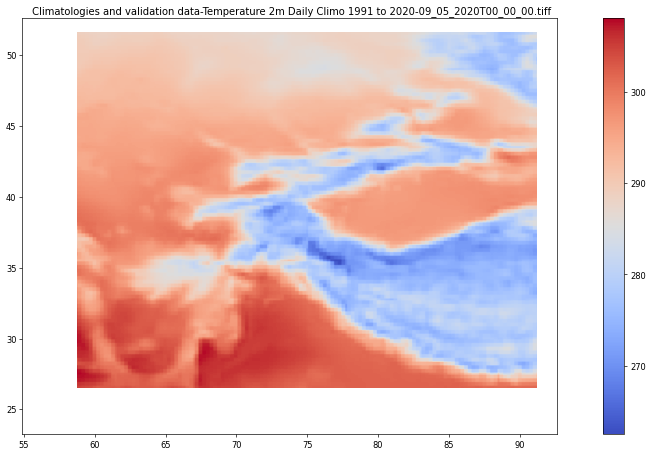

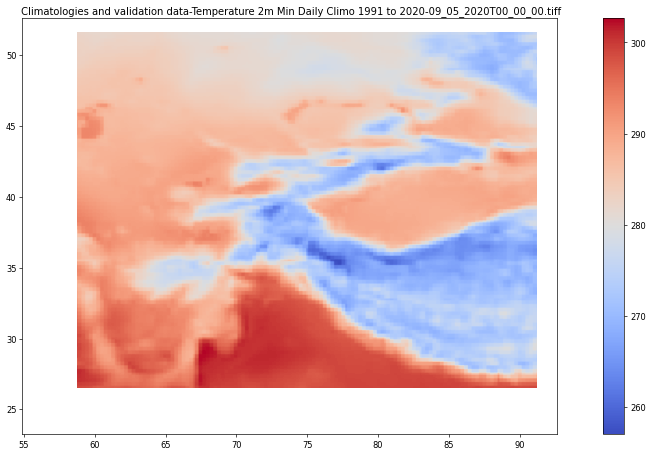

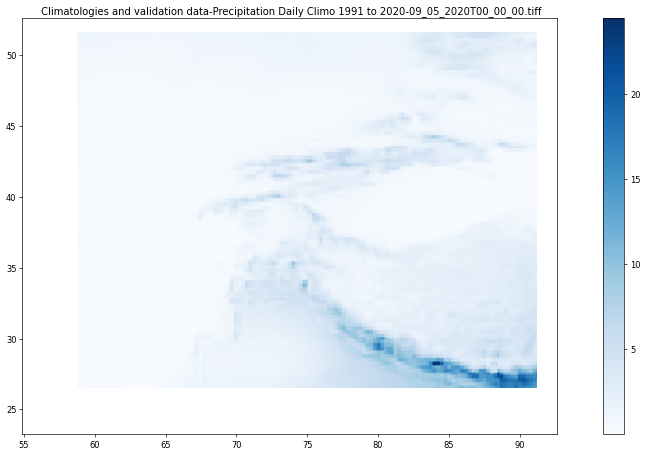

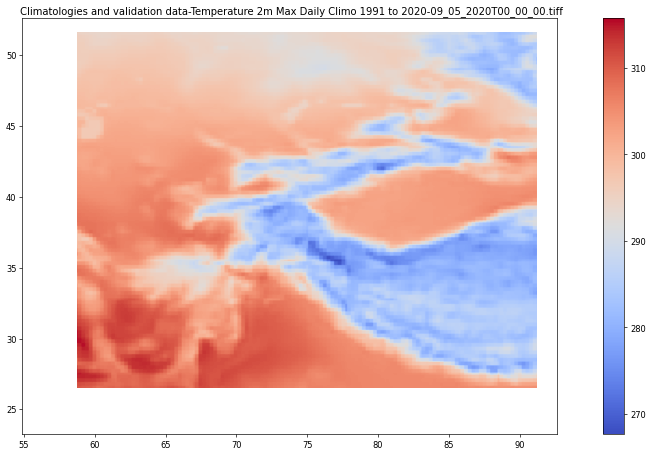

In [94]:
# Function to display the resulting Tiff(s).
climatologies_file_list = climatologies_result.list_files()
output_image_array = []
for file in climatologies_file_list:
    if file.endswith('.tiff'): #display the raster images
        with open(file+'.json', 'r') as summary_file:
            fileparms = json.load(summary_file)
        boundingBox=fileparms["boundingBox"]
        pixelStatistics=fileparms["rasterStatistics"]
        myextent=[boundingBox["minLongitude"],
                  boundingBox["maxLongitude"],
                  boundingBox["minLatitude"],
                  boundingBox["maxLatitude"]]  
        array_climatologies = np.array(PILImage.open(file))
        mask = (array_climatologies == -9999)
        # Masked array to exclude NO Data points from plotting
        masked_array = np.ma.masked_array(array_climatologies, mask)
        plt.figure(figsize = (20, 9), dpi=60) # Sets the size and resolution of the plot
        if 'Precipitation' in file:
            plt.imshow(masked_array,
                       cmap = 'Blues', 
                       vmin=pixelStatistics["pixelMin"], 
                       vmax=pixelStatistics["pixelMax"],
                       extent = myextent) # Loads the raster data and sets the colormap
        else:
            plt.imshow(masked_array,
                       cmap = 'coolwarm',
                       vmin=pixelStatistics["pixelMin"],
                       vmax=pixelStatistics["pixelMax"],
                       extent = myextent) # Loads the raster data and sets the colormap
        plt.colorbar() # Adds the color bar
        plt.title(" "+os.path.basename(file)) 
        output_image_path = os.path.splitext(os.path.basename(file))[0]+ ".png"
        output_image_array.append(output_image_path)
        # Save the figure
        plt.savefig(output_image_path, bbox_inches='tight')
        plt.close() 
        
for output_image in output_image_array:
    #display the raster images
    display(Image(output_image))

Each of the images above represents information on maximum,minimum and daily average temperature and precipitation values for the specified location and time period. The color gradient provides a visual representation of the magnitude and distribution of the climate data, making it easier to interpret regional differences and trends in climate conditions.

## References
- https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.255
- https://en.wikipedia.org/wiki/Climatology